<a href="https://colab.research.google.com/github/marcinwolter/tarcza/blob/main/tarcza.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
# prompt: random points on a plane within the radius R

import random
import numpy as np

from sklearn.neural_network import MLPRegressor
#from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
import pandas as pd
import pickle


# speed of sound
v_s = 34000 # cm/s


In [21]:
def monte_carlo_circle(R, R_mic, time_error, num_points):
    """
    Points within a circle of radius R using Monte Carlo simulation.

    Args:
        R: The radius of the circle.
        num_points: The number of random points to generate.

    Returns:
        A tuple containing:
            - x, y of the true points
            - four times measured (one is zero)
            - rotation flag
    """
    # microphone positions
    xy_mic = np.array([[0, R_mic], [R_mic, 0], [0, -R_mic], [-R_mic,0]])
    time = np.zeros((4))

    out_true = np.zeros((num_points, 2))
    out_measured = np.zeros((num_points, 4))
    rot_flag = np.zeros((num_points))
    inside_circle = 0

    while inside_circle < num_points:
        x = random.uniform(-R, R)
        y = random.uniform(-R, R)
        distance2 = x*x + y*y
        if distance2 <= R*R:
          for i in range(4):
            time[i] = np.sqrt((xy_mic[i,0]-x)**2 + (xy_mic[i,1]-y)**2)/v_s
            # introduce error
            time[i] = max(0,time[i]+random.gauss(0,time_error))

          i_min = np.argmin(time)

          for k in range(4):
            out_measured[inside_circle, k] = time[k]-time[i_min]
          rot_flag[inside_circle] = i_min

          out_true[inside_circle, 0] = x
          out_true[inside_circle, 1] = y

          inside_circle += 1
          #print(f"point: {x, y, inside_circle}")



    return out_true, out_measured, rot_flag



In [22]:
# neural network regression out_measured -> out_true
def regression(out_measured, out_true):
    X_train, X_test, y_train, y_test = train_test_split(out_measured, out_true,
                                                    random_state=1)

    #see https://scikit-learn.org/1.6/modules/generated/sklearn.neural_network.MLPRegressor.html
    regr = MLPRegressor(hidden_layer_sizes=(30,30), activation='relu', solver='adam',
                        alpha=0.0001, batch_size='auto', learning_rate='adaptive',
                        learning_rate_init=0.001, random_state=33, tol=0.0001,
                        verbose=True, warm_start=False, momentum=0.9, nesterovs_momentum=True,
                        early_stopping=True, validation_fraction=0.2, n_iter_no_change=100,
                        max_iter = 10000)
    regr.fit(X_train, y_train)

    #print(regr.predict(X_test[:4]))
    #print(y_test[:4])

    print("Regression score: ",regr.score(X_test, y_test))
    #print("Score: ",regr.score(X_train, y_train))

    return regr


meas: [[1.05629912e-04 0.00000000e+00 2.04240756e-05 1.16354737e-04]
 [8.79086736e-05 0.00000000e+00 2.18062494e-05 1.05127132e-04]
 [2.40152371e-04 1.40662550e-04 0.00000000e+00 1.65119038e-04]
 [0.00000000e+00 1.42521715e-04 2.22140621e-04 1.33574460e-04]]
rot: [1. 1. 2. 0.]
(10000, 2) (10000, 4) (10000,)
Iteration 1, loss = 3.10709062
Validation score: -0.001235
Iteration 2, loss = 3.10563243
Validation score: -0.000695
Iteration 3, loss = 3.10494235
Validation score: -0.000469
Iteration 4, loss = 3.10489076
Validation score: -0.000483
Iteration 5, loss = 3.10472628
Validation score: -0.000547
Iteration 6, loss = 3.10493099
Validation score: -0.000609
Iteration 7, loss = 3.10499443
Validation score: -0.000384
Iteration 8, loss = 3.10497667
Validation score: -0.000534
Iteration 9, loss = 3.10506970
Validation score: -0.000717
Iteration 10, loss = 3.10657348
Validation score: -0.000603
Iteration 11, loss = 3.10485389
Validation score: -0.000393
Iteration 12, loss = 3.10463358
Validati

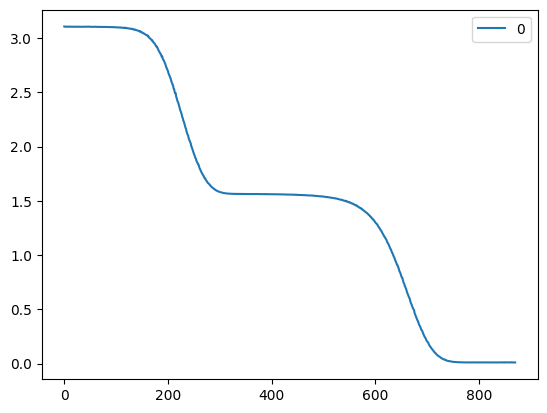

In [23]:
# Example usage:
radius = 5.0  # Set the radius of the circle
num_points = 10000  # Set the number of random points
R_mic = 7.
time_error = 0.000001 # 0.00001

out_true, out_meas, rot_flag = monte_carlo_circle(radius, R_mic, time_error, num_points)
#print(f"true: {out_true[0:4]}")
print(f"meas: {out_meas[0:4]}")
print(f"rot: {rot_flag[0:4]}")
print(out_true.shape, out_meas.shape, rot_flag.shape)

regr = regression(out_meas, out_true)


# Plot the 'loss_curve_' protery on model to see how well we are learning over the iterations
pd.DataFrame(regr.loss_curve_).plot()

# save the model to disk
#filename = 'regr_model.sav'
#pickle.dump(regr, open(filename, 'wb'))

# load the model from disk
#regr = pickle.load(open(filename, 'rb'))

# Test regressor on the new data
out_true, out_meas, rot_flag = monte_carlo_circle(radius, R_mic, time_error, num_points)
predicted = regr.predict(out_meas)
print("true: ")
print(out_true[0:4])
print("predicted:")
print(predicted[0:4])
print("Regression score: ",regr.score(out_meas, out_true))